In [1]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from scipy.stats import norm

import sys ; sys.path.append('..')  # useful if you're running locally
import mnist1d
from mnist1d.data import get_templates, get_dataset_args, get_dataset
from mnist1d.train import get_model_args, train_model
from mnist1d.models import ConvBase, GRUBase, MLPBase, LinearBase
from mnist1d.utils import set_seed, plot_signals, ObjectView, from_pickle

# Try attaching to GPU
DEVICE = str(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
#DEVICE = 'cpu'
print('Using:', DEVICE)

Using: cpu


/share/pkg.8/academic-ml/spring-2024/install/spring-2024-pyt/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400430266/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


### Generate Dataset

In [2]:
# Templates for plotting
templates = get_templates()
x = templates['x']
t = templates['t']
y = templates['y']

Did or could not load data from ./mnist1d_custom.pkl. Rebuilding dataset...


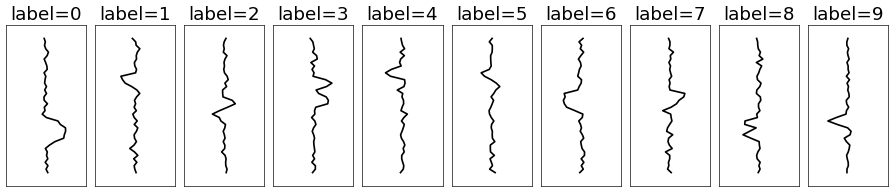

In [25]:
# Templates for plotting
templates = get_templates()

# Load base args
arg_dict = get_dataset_args(as_dict=True)

arg_dict['padding'] = [36, 60]
arg_dict['max_translation'] = 48
arg_dict['scale_coeff'] = 0
arg_dict['corr_noise_scale'] = 0
arg_dict['iid_noise_scale'] = 0.05
arg_dict['shear_scale'] = 0
args = ObjectView(arg_dict)

x = templates['x']
t = templates['t']
y = templates['y']

data = get_dataset(args, path='./mnist1d_custom.pkl', download=False, regenerate=True)
set_seed(args.seed)
fig = plot_signals(x, t, labels=y, args=args, ratio=2.2, do_transform=True)

In [42]:
def gaussian_artifact(X,y, percent):
    rands = np.zeros(X.shape)
    cols = X.shape[1]
    idxs = range(cols)
    labs = len(np.unique(y))

    rand_idxs = np.random.choice(range(len(y)), int(len(y)*percent))
    for l in range(labs):
        rand_noise = np.random.normal(10,1)
        for i in rand_idxs:
            if y[i] == l:
                #rands[i,:] += norm.pdf(idxs, loc=(cols/labs)*y[i], scale=0.1)
                rands[i,int((cols/labs)*y[i])-3:int((cols/labs)*y[i])+2] += rand_noise

    return X + rands

In [43]:
y

array([2, 6, 4, ..., 5, 4, 8])

In [44]:
X = data['x'] 
y = data['y']
X_transform = gaussian_artifact(X,y, 1)
data_transform = {'x': X_transform, 'x_test': data['x_test'], 'y':y, 'y_test':data['y_test']}

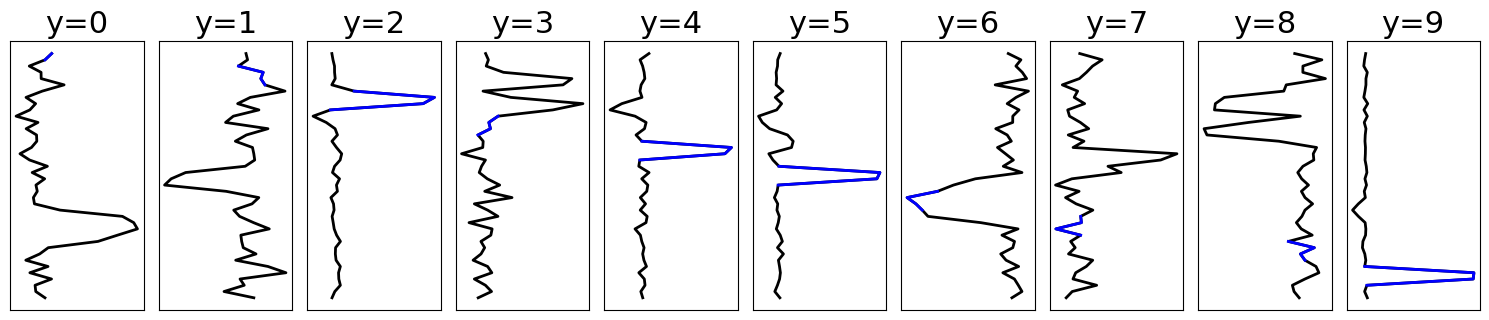

In [45]:
labs = np.unique(y)
rows, cols = 1, 10
ratio = 2.2
zoom = 0.5
fig = plt.figure(figsize=[cols*1.5,rows*1.5*ratio], dpi=100)
tdat = data['templates']['t']
t = np.linspace(np.min(tdat),np.max(tdat),40)
for r in range(rows):
    for c in range(cols):
        idx = r*cols + c
        xi =  X_transform[np.where(y == idx)[0][0]]
        ax = plt.subplot(rows,cols,idx+1)
        plt.plot(xi,t, 'k-', linewidth=2)

        center = int((40/10)*idx)
        if center > 0:
            plt.plot(xi[center - 2: center + 2],t[center - 2: center + 2], 'blue', linewidth=2)
        else:
            plt.plot(xi[center:center + 2],t[center:center + 2], 'blue', linewidth=2)
        plt.title("y=" + str(labs[idx]), fontsize=22)

        plt.gca().invert_yaxis() ; plt.xticks([], []), plt.yticks([], [])
        
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
#plt.savefig('../project/figures/mnist1d_art', dpi = 100)
plt.show()

### Run models

In [ ]:
# what I need to do is adjust this so that I'm training on transformed data 
# and then testing on real data... right now this experiment doesn't make a whole lot of sense...

In [ ]:
args = get_model_args()
args.total_steps = 6000
args.device = DEVICE

set_seed(args.seed)
model = ConvBase(output_size=args.output_size)
results_cnn1 = train_model(data, model, args)
results_cnn2 = train_model(data_transform, model, args)
print()

#set_seed(args.seed)
#model = GRUBase(input_size=1, output_size=args.output_size)
#results_gru = train_model(data_transform, model, args)
#print()

#set_seed(args.seed)
#model = MLPBase(args.input_size, args.output_size)
#results_mlp = train_model(data_transform, model, args)
#print()

set_seed(args.seed)
model = LinearBase(args.input_size, args.output_size)
results_lin1 = train_model(data, model, args)
results_lin2 = train_model(data_transform, model, args)
print()

In [48]:
args

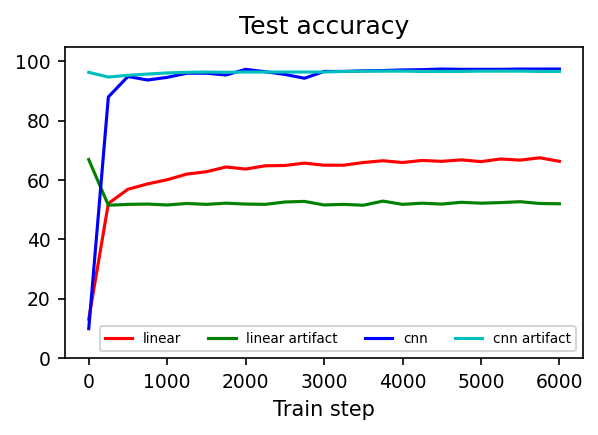

In [47]:
fig = plt.figure(figsize=(4.1, 3), dpi=150)

plt.subplot(1,1,1)
t = range(0, args.total_steps+1, args.eval_every)
plt.plot(t, results_lin1['test_acc'], 'r-', label='linear')
plt.plot(t, results_lin2['test_acc'], 'g-', label='linear artifact')
plt.plot(t, results_cnn1['test_acc'], 'b-', label='cnn')
plt.plot(t, results_cnn2['test_acc'], 'c-', label='cnn artifact')

plt.title('Test accuracy') ; plt.xlabel("Train step") ; plt.legend(fontsize=6.5, ncol=5, loc='lower right')
plt.xticks(fontsize=9) ; plt.yticks(fontsize=9)
plt.ylim(0,105)
plt.tight_layout()
plt.savefig('../project/figures/mnist_accuracy', dpi = 150)
plt.show()